# Forecasting Covid Deaths & Cases in the US

## Capstone Project One: Springboard Data Science career track

## Notebook by Marcelo Fuentes

### Introduction:

### 1. The Problem:

The aim of this project is to use confirmed Covid figures to perform a forecast of future Confirmed cases using, autoregressive models as well as ridge regressions For our ARIMA model we will use only the confirmed cases time series but for our vector autoregressive model we will also weather data, lastly for our Ridge regression we will be using a lagged holiday schedule variable as a parameter.

### 2. Data:

In order to create my final dataframe I had to source the Covid data from a Github repository and the weather data came from the NOAA.

### 3. The question of interest:

Using all of the variables above, how accurate a forecast of covid figures (reported cases and deaths) can be perform by using multiple variables both quantitative and qualitative



### 4. Import the necessary modules

To start, let's first import all the necessary modules and libraries and read the data set into the Pandas dataframe.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from IPython.core.interactiveshell import InteractiveShell #This package and the command below allow for the Jupyter notebook
#to print all the outputs and NOT just the final row
InteractiveShell.ast_node_interactivity = "all" #this command allows all outputs to be printed, not just the last command
# Show plots inline
%matplotlib inline

### 5 . Loading the data and double checking my headers
In this section I am loading my data from my local repositories. The last file I uploaded is my mapping file which I will be using to ensure I can perform inner joins on all databases

In [2]:
df = pd.read_csv('Github - Covid Data\Github-CovidData-20200323-20201231.csv')

In [3]:
#Basic statistics of the dataset
df.info()
df.describe
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869382 entries, 0 to 869381
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           869382 non-null  int64  
 1   FIPS                 869382 non-null  float64
 2   Admin2               869382 non-null  object 
 3   Province_State       869382 non-null  object 
 4   Country_Region       869382 non-null  object 
 5   Last_Update          869382 non-null  object 
 6   Lat                  869382 non-null  float64
 7   Long_                869382 non-null  float64
 8   Confirmed            869382 non-null  int64  
 9   Deaths               869382 non-null  float64
 10  Recovered            869382 non-null  float64
 11  Active               869382 non-null  float64
 12  Combined_Key         869382 non-null  object 
 13  as_of_date           869382 non-null  object 
 14  Incidence_Rate       512232 non-null  float64
 15  Case-Fatality_Rat

<bound method NDFrame.describe of         Unnamed: 0     FIPS      Admin2  Province_State Country_Region  \
0                0  45001.0   Abbeville  South Carolina             US   
1                1  22001.0      Acadia       Louisiana             US   
2                2  51001.0    Accomack        Virginia             US   
3                3  16001.0         Ada           Idaho             US   
4                4  19001.0       Adair            Iowa             US   
...            ...      ...         ...             ...            ...   
869377        3917  56037.0  Sweetwater         Wyoming             US   
869378        3918  56039.0       Teton         Wyoming             US   
869379        3919  56041.0       Uinta         Wyoming             US   
869380        3921  56043.0    Washakie         Wyoming             US   
869381        3922  56045.0      Weston         Wyoming             US   

                Last_Update        Lat       Long_  Confirmed  Deaths  \
0   

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,as_of_date,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio
0,0,45001.0,Abbeville,South Carolina,US,2020-03-23 23:19:34,34.223334,-82.461707,1,0.0,0.0,0.0,"Abbeville, South Carolina, US",03-23-2020,NaN,NaN,NaN,NaN
1,1,22001.0,Acadia,Louisiana,US,2020-03-23 23:19:34,30.295065,-92.414197,1,0.0,0.0,0.0,"Acadia, Louisiana, US",03-23-2020,NaN,NaN,NaN,NaN
2,2,51001.0,Accomack,Virginia,US,2020-03-23 23:19:34,37.767072,-75.632346,1,0.0,0.0,0.0,"Accomack, Virginia, US",03-23-2020,NaN,NaN,NaN,NaN
3,3,16001.0,Ada,Idaho,US,2020-03-23 23:19:34,43.452658,-116.241552,13,0.0,0.0,0.0,"Ada, Idaho, US",03-23-2020,NaN,NaN,NaN,NaN
4,4,19001.0,Adair,Iowa,US,2020-03-23 23:19:34,41.330756,-94.471059,1,0.0,0.0,0.0,"Adair, Iowa, US",03-23-2020,NaN,NaN,NaN,NaN


#### Before we can work with our time series we need to:
1. change the as_of_date to a date time data type
2. join this data to our states codes and mapping table to get the Province state short code
3. check for any nan values 

In [4]:
#Change the data type to time - NOTE the last_update column is asynchronous with the as of date (some data was backfilled)
# We will also trim our database and have it start from July 1st as opposed to March 23rd, to avoid issues with initial trends
df['as_of_date'] = pd.to_datetime(df['as_of_date'])
df = df[df['as_of_date']>='07-01-2020']
#verify the change was made
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583280 entries, 286102 to 869381
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           583280 non-null  int64         
 1   FIPS                 583280 non-null  float64       
 2   Admin2               583280 non-null  object        
 3   Province_State       583280 non-null  object        
 4   Country_Region       583280 non-null  object        
 5   Last_Update          583280 non-null  object        
 6   Lat                  583280 non-null  float64       
 7   Long_                583280 non-null  float64       
 8   Confirmed            583280 non-null  int64         
 9   Deaths               583280 non-null  float64       
 10  Recovered            583280 non-null  float64       
 11  Active               583280 non-null  float64       
 12  Combined_Key         583280 non-null  object        
 13  as_of_dat

In [5]:
#Load states mapping table
states_mapping = pd.read_csv('States and Codes Mappings\State Names Codes and Mappings.csv')

In [6]:
#Perform a left join using the mapping table
df_mapped_for_joins = df.merge(states_mapping, how='left',left_on = 'FIPS', right_on='FIPS')
#verify the join worked
df = df_mapped_for_joins
df.head()
df.info()

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,as_of_date,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio,State,Code
0,0,45001.0,Abbeville,South Carolina,US,2020-07-02 04:33:46,34.223334,-82.461707,113,0.0,0.0,113.0,"Abbeville, South Carolina, US",2020-07-01,460.716761,0.000000,NaN,NaN,Abbeville County,SC
1,1,22001.0,Acadia,Louisiana,US,2020-07-02 04:33:46,30.295065,-92.414197,919,37.0,0.0,882.0,"Acadia, Louisiana, US",2020-07-01,1481.183012,4.026115,NaN,NaN,Acadia Parish,LA
2,2,51001.0,Accomack,Virginia,US,2020-07-02 04:33:46,37.767072,-75.632346,1043,14.0,0.0,1029.0,"Accomack, Virginia, US",2020-07-01,3227.503404,1.342282,NaN,NaN,Accomack County,VA
3,3,16001.0,Ada,Idaho,US,2020-07-02 04:33:46,43.452658,-116.241552,2288,23.0,0.0,2265.0,"Ada, Idaho, US",2020-07-01,475.095881,1.005245,NaN,NaN,Ada County,ID
4,4,19001.0,Adair,Iowa,US,2020-07-02 04:33:46,41.330756,-94.471059,15,0.0,0.0,15.0,"Adair, Iowa, US",2020-07-01,209.731544,0.000000,NaN,NaN,Adair County,IA


<class 'pandas.core.frame.DataFrame'>
Int64Index: 583280 entries, 0 to 583279
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           583280 non-null  int64         
 1   FIPS                 583280 non-null  float64       
 2   Admin2               583280 non-null  object        
 3   Province_State       583280 non-null  object        
 4   Country_Region       583280 non-null  object        
 5   Last_Update          583280 non-null  object        
 6   Lat                  583280 non-null  float64       
 7   Long_                583280 non-null  float64       
 8   Confirmed            583280 non-null  int64         
 9   Deaths               583280 non-null  float64       
 10  Recovered            583280 non-null  float64       
 11  Active               583280 non-null  float64       
 12  Combined_Key         583280 non-null  object        
 13  as_of_date    

In [7]:
#Feature selection
df.columns
df = df[['FIPS','Confirmed', 'Deaths','as_of_date']]

Index(['Unnamed: 0', 'FIPS', 'Admin2', 'Province_State', 'Country_Region',
       'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'Combined_Key', 'as_of_date', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Incident_Rate', 'Case_Fatality_Ratio', 'State',
       'Code'],
      dtype='object')

In [8]:
#As an extra step we need to set the index equal to the as_of_date for the purposes of this analysis
# df['as_of_date'] = pd.to_datetime(df['as_of_date'])
df = df.set_index('as_of_date')
df['as_of_date'] = df.index
df.head()
df.info()

,FIPS,Confirmed,Deaths,as_of_date
as_of_date,,,,
2020-07-01,45001.0,113,0.0,2020-07-01
2020-07-01,22001.0,919,37.0,2020-07-01
2020-07-01,51001.0,1043,14.0,2020-07-01
2020-07-01,16001.0,2288,23.0,2020-07-01
2020-07-01,19001.0,15,0.0,2020-07-01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 583280 entries, 2020-07-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   FIPS        583280 non-null  float64       
 1   Confirmed   583280 non-null  int64         
 2   Deaths      583280 non-null  float64       
 3   as_of_date  583280 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 22.3 MB


### 6 . EDA (Exploratory Data Analysis) - Covid Time Series
In this section I am going to perform some exploratory data analysis on my dataset to ensure that there are no gaps, the trends I see follow the behavior I would expect, etc. 

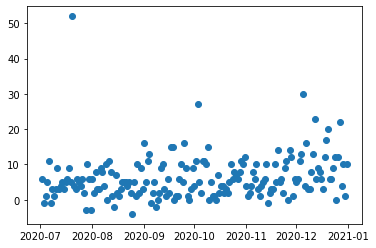

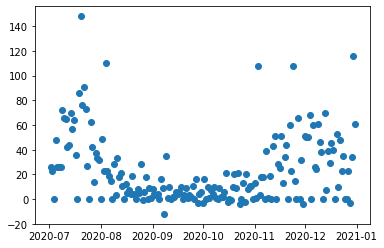

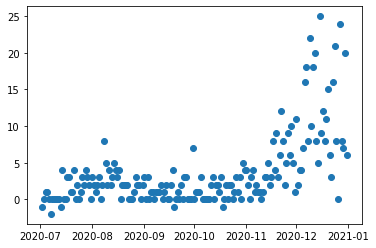

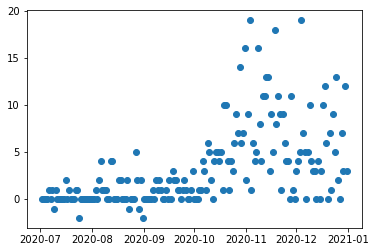

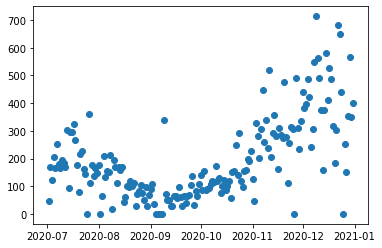

In [9]:
#Basic scatter plots for 5 different FIPS in 5 different states INTRA DAY DIFFERENCE CONFIRMED CASES ONLY
#For FIPS 45001,22001.51001,19001.0,16001.0
df_1 = df[df['FIPS'] == 45001]
plt.scatter(x=df_1['as_of_date'],y=df_1['Confirmed'].diff())
plt.show()

df_2 = df[df['FIPS'] == 22001]
plt.scatter(x=df_2['as_of_date'],y=df_2['Confirmed'].diff())
plt.show()

df_3 = df[df['FIPS'] == 51001]
plt.scatter(x=df_3['as_of_date'],y=df_3['Confirmed'].diff())
plt.show()

df_4 = df[df['FIPS'] == 19001]
plt.scatter(x=df_4['as_of_date'],y=df_4['Confirmed'].diff())
plt.show()

df_5 = df[df['FIPS'] == 16001]
plt.scatter(x=df_5['as_of_date'],y=df_5['Confirmed'].diff())
plt.show()

### Assumptions and conclusions so far
So far I would say the trends in 'Confirmed cases' follow predomintantly an exponential pattern. The following plots will be derived using the percentage changes for the time series, we will use this to later perform autocorrelation or partial autocorrelation assessments


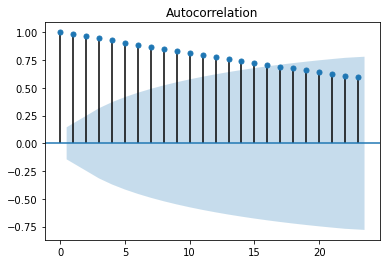

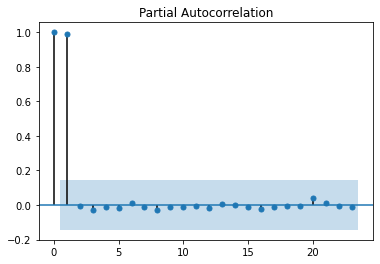

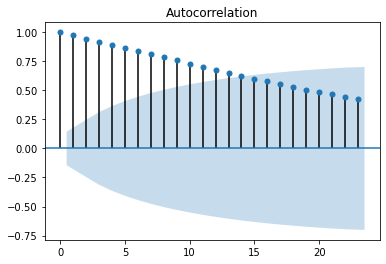

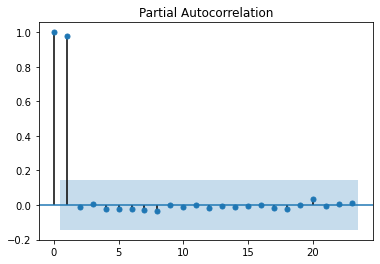

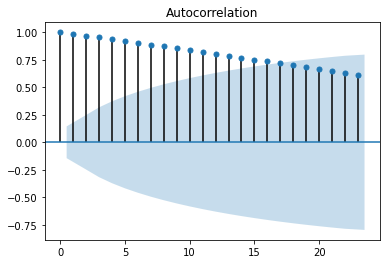

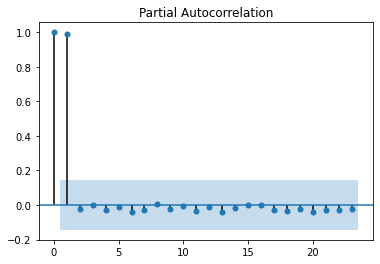

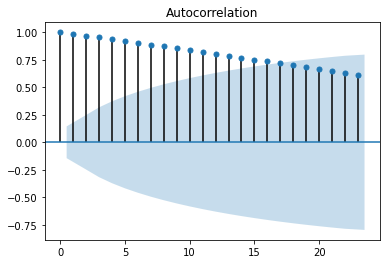

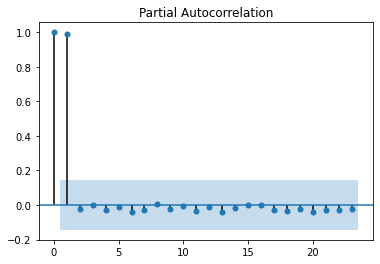

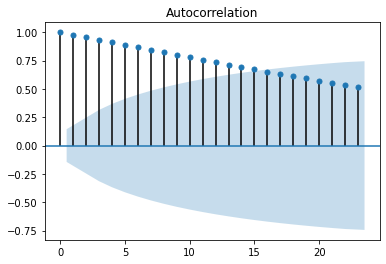

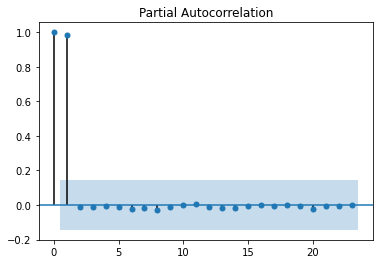

In [10]:
#The next step is to plot the Autocorrelation Functions and Partial Autocorrelation Functions
#use alpha 0.05 for my plots
from statsmodels.graphics.tsaplots import plot_acf as plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as plot_pacf

#the ACF plots only work with time series data so I need to see only the confirmed variable, note the axis is date time
df_1 = df[df['FIPS'] == 45001]
df_1 = df_1['Confirmed']
df_1_acf = plot_acf(df_1, alpha=0.05)
df_1_pacf = plot_pacf(df_1, alpha=0.05)

df_2 = df[df['FIPS'] == 22001]
df_2 = df_2['Confirmed']
df_2_acf = plot_acf(df_2, alpha=0.05)
df_2_pacf = plot_pacf(df_2, alpha=0.05)

df_3 = df[df['FIPS'] == 19001]
df_3 = df_3['Confirmed']
df_3_acf = plot_acf(df_3, alpha=0.05)
df_3_pacf = plot_pacf(df_3, alpha=.05)

df_4 = df[df['FIPS'] == 19001]
df_4 = df_4['Confirmed']
df_4_acf = plot_acf(df_4, alpha=0.05)
df_4_pacf = plot_pacf(df_4, alpha=0.05)

df_5 = df[df['FIPS'] == 16001]
df_5 = df_5['Confirmed']
df_5_acf = plot_acf(df_5, alpha=0.05)
df_5_pacf = plot_pacf(df_5, alpha=0.05)

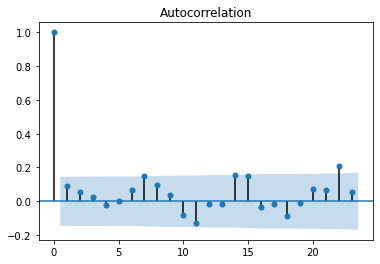

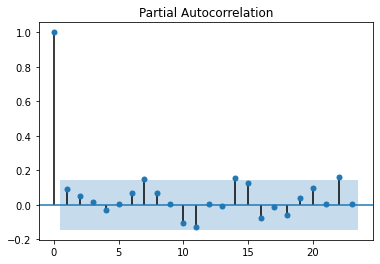

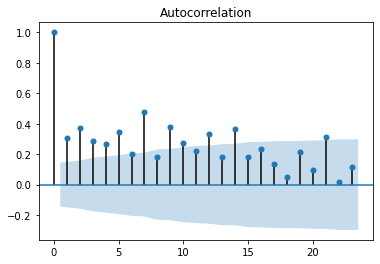

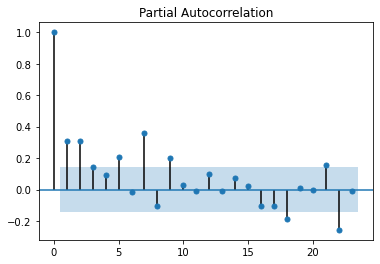

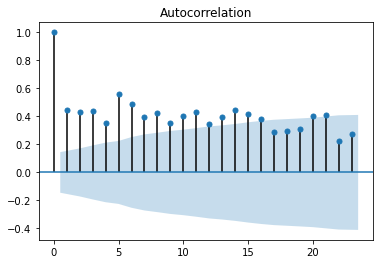

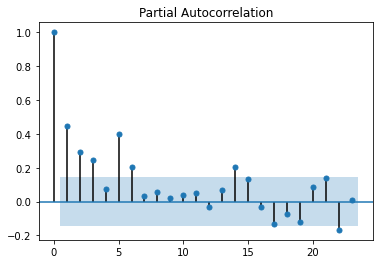

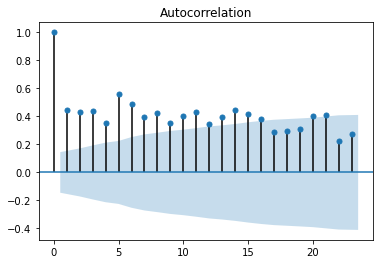

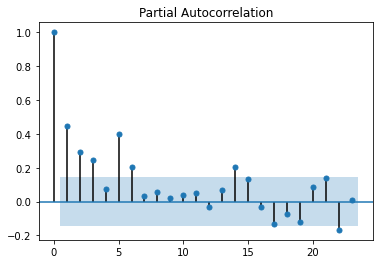

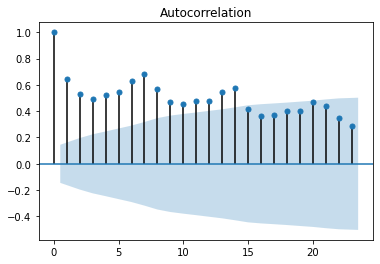

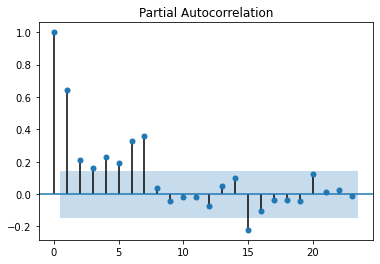

In [11]:
#The next step is to plot the Autocorrelation Functions and Partial Autocorrelation Functions
#use alpha 0.05 for my plots
from statsmodels.graphics.tsaplots import plot_acf as plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as plot_pacf

#the ACF plots only work with time series data so I need to see only the confirmed variable, note the axis is date time
df_1 = df[df['FIPS'] == 45001]
df_1 = df_1['Confirmed'].diff().dropna()
df_1_acf = plot_acf(df_1, alpha=0.05)
df_1_pacf = plot_pacf(df_1, alpha=0.05)

df_2 = df[df['FIPS'] == 22001]
df_2 = df_2['Confirmed'].diff().dropna()
df_2_acf = plot_acf(df_2, alpha=0.05)
df_2_pacf = plot_pacf(df_2, alpha=0.05)

df_3 = df[df['FIPS'] == 19001]
df_3 = df_3['Confirmed'].diff().dropna()
df_3_acf = plot_acf(df_3, alpha=0.05)
df_3_pacf = plot_pacf(df_3, alpha=.05)

df_4 = df[df['FIPS'] == 19001]
df_4 = df_4['Confirmed'].diff().dropna()
df_4_acf = plot_acf(df_4, alpha=0.05)
df_4_pacf = plot_pacf(df_4, alpha=0.05)

df_5 = df[df['FIPS'] == 16001]
df_5 = df_5['Confirmed'].diff().dropna()
df_5_acf = plot_acf(df_5, alpha=0.05)
df_5_pacf = plot_pacf(df_5, alpha=0.05)

### Assumptions and conclusions so far
So far we can deduce that the model we will be using to produce this forecast would be an AR(1) model based on the partial autocorrelation function plots shown above, since after AR(1) the partial autocorrelation stays around 0 for the undifferenced series. In terms of model order (p, d, q) this would imply that we now know that the first parameter must be 1, therefore our parameters thus far look like so (1, d, q). Furthermore, given that the autocorrelation trend is very persistently similar, it can be said that it does not follow a random walk. Furthermore, as it relates to the difference parameter, it could be said that a first order difference would be congruent which leaves only the "q" parameter left. Therefore our model order should look like so (1, 1, q) where q is still to be determined. 

### 7.1 - ARIMA Model
Auto Regressive Integrated Moving Average (ARIMA) - 
Each of these components are explicitly specified in the model as a parameter. A standard notation of ARIMA(p,d,q) is used where the parameters are substituted with  integer values to quickly indicate the specific ARIMA model being used. Where p, indicates the regression AR(p) criteria d, indicates the differentiation criteria and q, indicates the moving average criteria MA(q)

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.


#### Daily and Aggregate cases in the US
Below we can see a plot of the aggregate and daily change in Covid cases in the US, we will be using our final model to forecasting each individual county and finally aggregate them to forecast the total value for the US. 

,as_of_date,Confirmed
0,2020-07-01,2655135
1,2020-07-02,2707665
2,2020-07-03,2761290
3,2020-07-04,2806342
4,2020-07-05,2854711


Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Covid Cases')

Text(0.5, 1.0, 'Daily Change in Covid cases in the US')

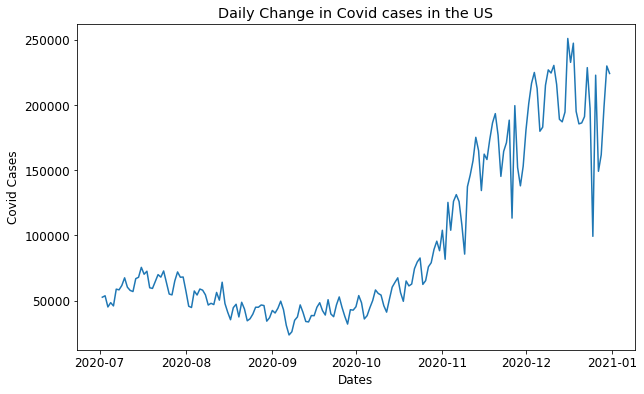

In [12]:
df_US = df[['FIPS','Confirmed']]
df_US = df_US[df_US['FIPS']>0]
df_US = df_US.resample('1d').sum()
df_US = df_US['Confirmed'] 
df_US = df_US.reset_index()
df_US.head()

plt.rc('font', size=12)
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_US.as_of_date, df_US.Confirmed.diff(), color='tab:blue', label='Windspeed')

ax1.set_xlabel('Dates')
ax1.set_ylabel('Covid Cases')
ax1.set_title('Daily Change in Covid cases in the US')

In [13]:
# Define df_5 once again as it will be used for our base case analysis
df_5 = df[df['FIPS'] == 16001]
df_5 = df_5['Confirmed']


In [14]:
# Function called evaluate_arima_model to find the MSE of a single ARIMA model 
from statsmodels.tsa.arima_model import ARIMA
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.9) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [15]:
# Function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [16]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 2)]
d_values = [x for x in range(0, 2)]
q_values = [x for x in range(0, 6)]

In [ ]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(df_5, p_values, d_values, q_values)

Based on  Mean Squared Error we are unable to find an optimum for our ARIMA model, the next step will be to evaluate it based on AIC and BIC

In [17]:
# Function called evaluate_arima_model to find the AIC and BIC of a single ARIMA model 
from statsmodels.tsa.arima_model import ARIMA
def evaluate_arima_model_AIC(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.9) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    AIC = model_fit.aic
    # Return the error
    return AIC

In [18]:
# Function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models_AIC(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    AIC = evaluate_arima_model_AIC(dataset, order)
                    if AIC < best_score:
                        best_score, best_cfg = AIC, order
                    print('ARIMA%s AIC=%.3f' % (order, AIC))
                except:
                    continue
    return print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [19]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [1]
d_values = [0,1]
q_values = [x for x in range(0, 6)]

In [83]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models_AIC(df_5, p_values, d_values, q_values)

Best ARIMANone AIC=inf


Based on the AIC we were unable to find the optimum for this model.

# Conclusions so far

Given that the partial autocorrelation graphs indicated that our model should be of p = 1, that the data we are trying to output has been differenced once i.e. d=1 however, since we were unable to find optima from our optimization processes we will leave this ARIMA model specified as ARIMA (1, 1, 0) with q = 0.

### Final ARIMA model ARIMA(1,1,0)

In [49]:
#For the base case we will use df_1 which has the data for FIPS 45001

df_5 = df[df['FIPS'] == 16001]
df_5 = df_5['Confirmed']

p=1
d=1
q=0
model = ARIMA(df_5, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast()

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [50]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  183
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1127.624
Method:                       css-mle   S.D. of innovations            114.600
Date:                Tue, 05 Jan 2021   AIC                           2261.248
Time:                        21:50:07   BIC                           2270.877
Sample:                             1   HQIC                          2265.151
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               197.1394     23.863      8.261      0.000     150.370     243.909
ar.L1.D.Confirmed     0.6485      0.056     11.493      0.000       0.538       0.759
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5420           +0.0000j            1.5420            0.0000
-----------------------------------------------------------------------------
"""

### Visualize the results of the base case

In [51]:
df_5_predict = model_fit.predict()
print(df_5_predict)
#df_1[0]

3024      197.139403
6046      100.421126
9074      180.187759
12105     149.707826
15137     201.588564
             ...    
567863    233.365515
571056    166.569066
574249    299.513455
577442    437.645918
580635    295.622400
Length: 183, dtype: float64


<Figure size 1080x720 with 0 Axes>

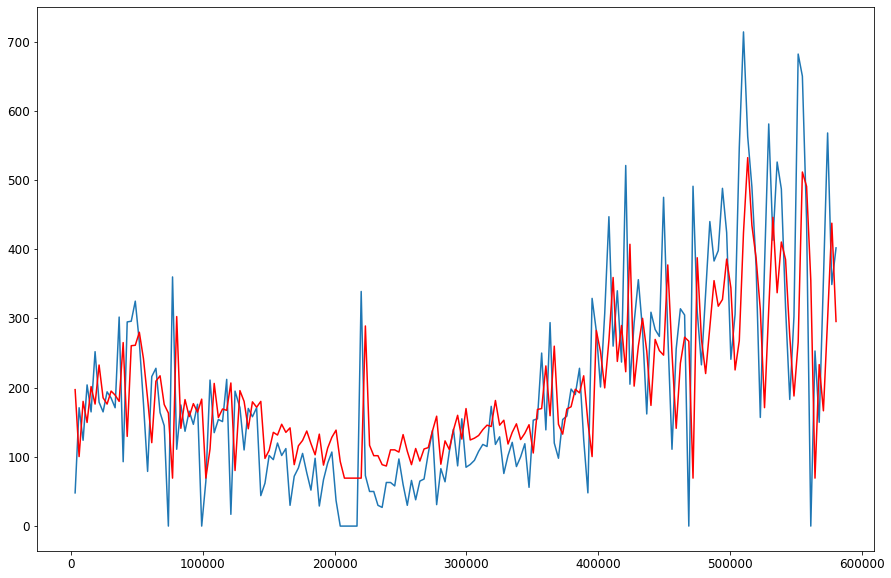

In [57]:
# Forecasting the results one month out
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(df_5.diff())
plt.plot(model_fit.predict(), color = 'red')

### Apply the model to all counties to create US forecast




In [24]:
df = df_mapped_for_joins
df = df[['FIPS','Confirmed','as_of_date']]
df.head()
df.shape
df.info()

,FIPS,Confirmed,as_of_date
0,45001.0,113,2020-07-01
1,22001.0,919,2020-07-01
2,51001.0,1043,2020-07-01
3,16001.0,2288,2020-07-01
4,19001.0,15,2020-07-01


(583280, 3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583280 entries, 0 to 583279
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   FIPS        583280 non-null  float64       
 1   Confirmed   583280 non-null  int64         
 2   as_of_date  583280 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 17.8 MB


In [34]:
# Create a list of unique FIPS which will act as my iterating variable 
# The list of FIPS was broken up into 4 portions to make computationally easier loops.
FIPS_list = df['FIPS'].unique()
FIPS_list = [x for x in FIPS_list if str(x) != 'nan']
FIPS_list1 = FIPS_list[:1000]
FIPS_list2 = FIPS_list[slice(1000, 2000)]
FIPS_list3 = FIPS_list[slice(2000, 3000)]
FIPS_list4 = FIPS_list[3000:]

In [33]:
#Run the model with the specified parameters for each FIPS

forecasted_values_US = []
forecasted_values_US = pd.DataFrame(forecasted_values_US)

for FIP in FIPS_list1:
    df_all_US = df[df['FIPS']==FIP]
    df_all_US = df_all_US.set_index('as_of_date')
    df_all_US = df_all_US['Confirmed'].dropna()
    model = ARIMA(df_all_US, order=(1,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    predicted_values = model_fit.predict()
    predicted_values = pd.DataFrame(predicted_values, columns=['Confirmed'])
    predicted_values = predicted_values.reset_index()
    predicted_values['FIPS'] = FIP
    forecasted_values_US = forecasted_values_US.append(predicted_values) 

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

In [35]:
for FIP in FIPS_list2:
    df_all_US = df[df['FIPS']==FIP]
    df_all_US = df_all_US.set_index('as_of_date')
    df_all_US = df_all_US['Confirmed'].dropna()
    model = ARIMA(df_all_US, order=(1,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    predicted_values = model_fit.predict()
    predicted_values = pd.DataFrame(predicted_values, columns=['Confirmed'])
    predicted_values = predicted_values.reset_index()
    predicted_values['FIPS'] = FIP
    forecasted_values_US = forecasted_values_US.append(predicted_values) 

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

In [36]:
for FIP in FIPS_list3:
    df_all_US = df[df['FIPS']==FIP]
    df_all_US = df_all_US.set_index('as_of_date')
    df_all_US = df_all_US['Confirmed'].dropna()
    model = ARIMA(df_all_US, order=(1,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    predicted_values = model_fit.predict()
    predicted_values = pd.DataFrame(predicted_values, columns=['Confirmed'])
    predicted_values = predicted_values.reset_index()
    predicted_values['FIPS'] = FIP
    forecasted_values_US = forecasted_values_US.append(predicted_values) 

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

In [37]:
for FIP in FIPS_list4:
    df_all_US = df[df['FIPS']==FIP]
    df_all_US = df_all_US.set_index('as_of_date')
    df_all_US = df_all_US['Confirmed'].dropna()
    model = ARIMA(df_all_US, order=(1,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    predicted_values = model_fit.predict()
    predicted_values = pd.DataFrame(predicted_values, columns=['Confirmed'])
    predicted_values = predicted_values.reset_index()
    predicted_values['FIPS'] = FIP
    forecasted_values_US = forecasted_values_US.append(predicted_values) 

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.p

In [40]:
#This dataframe has the result the ARIMA forecast
###
forecasted_values_US
###
df_US_forecast = forecasted_values_US
df_US_forecast['as_of_date']=df_US_forecast['index']
df_US_forecast = df_US_forecast
df_US_forecast.head()

,index,Confirmed,FIPS,as_of_date
0,2020-07-02,6.351491,45001.0,NaT
1,2020-07-03,6.320103,45001.0,NaT
2,2020-07-04,5.695011,45001.0,NaT
3,2020-07-05,5.873608,45001.0,NaT
4,2020-07-06,6.230804,45001.0,NaT
...,...,...,...,...
39,2020-12-27,-0.023280,48301.0,NaT
40,2020-12-28,-0.023280,48301.0,NaT
41,2020-12-29,-0.023280,48301.0,NaT
42,2020-12-30,-0.023280,48301.0,NaT


,index,Confirmed,FIPS,as_of_date
0,2020-07-02,6.351491,45001.0,2020-07-02
1,2020-07-03,6.320103,45001.0,2020-07-03
2,2020-07-04,5.695011,45001.0,2020-07-04
3,2020-07-05,5.873608,45001.0,2020-07-05
4,2020-07-06,6.230804,45001.0,2020-07-06


In [41]:
df_US_forecast.columns
df_US_forecast = df_US_forecast[['Confirmed','FIPS','as_of_date']] 
df_US_forecast = df_US_forecast.set_index('as_of_date')
df_US_forecast.head()

Index(['index', 'Confirmed', 'FIPS', 'as_of_date'], dtype='object')

,Confirmed,FIPS
as_of_date,,
2020-07-02,6.351491,45001.0
2020-07-03,6.320103,45001.0
2020-07-04,5.695011,45001.0
2020-07-05,5.873608,45001.0
2020-07-06,6.230804,45001.0


In [42]:
df = df_mapped_for_joins

df.head()

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,as_of_date,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio,State,Code
0,0,45001.0,Abbeville,South Carolina,US,2020-07-02 04:33:46,34.223334,-82.461707,113,0.0,0.0,113.0,"Abbeville, South Carolina, US",2020-07-01,460.716761,0.000000,NaN,NaN,Abbeville County,SC
1,1,22001.0,Acadia,Louisiana,US,2020-07-02 04:33:46,30.295065,-92.414197,919,37.0,0.0,882.0,"Acadia, Louisiana, US",2020-07-01,1481.183012,4.026115,NaN,NaN,Acadia Parish,LA
2,2,51001.0,Accomack,Virginia,US,2020-07-02 04:33:46,37.767072,-75.632346,1043,14.0,0.0,1029.0,"Accomack, Virginia, US",2020-07-01,3227.503404,1.342282,NaN,NaN,Accomack County,VA
3,3,16001.0,Ada,Idaho,US,2020-07-02 04:33:46,43.452658,-116.241552,2288,23.0,0.0,2265.0,"Ada, Idaho, US",2020-07-01,475.095881,1.005245,NaN,NaN,Ada County,ID
4,4,19001.0,Adair,Iowa,US,2020-07-02 04:33:46,41.330756,-94.471059,15,0.0,0.0,15.0,"Adair, Iowa, US",2020-07-01,209.731544,0.000000,NaN,NaN,Adair County,IA


,as_of_date,Confirmed
0,2020-07-02,92924.124799
1,2020-07-03,66734.116117
2,2020-07-04,67407.841420
3,2020-07-05,62927.563299
4,2020-07-06,68015.533767


Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Covid Cases')

Text(0.5, 1.0, 'Forecasted Daily change in covid cases in the US')

Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Covid Cases')

Text(0.5, 1.0, 'Daily Change in Covid cases in the US')

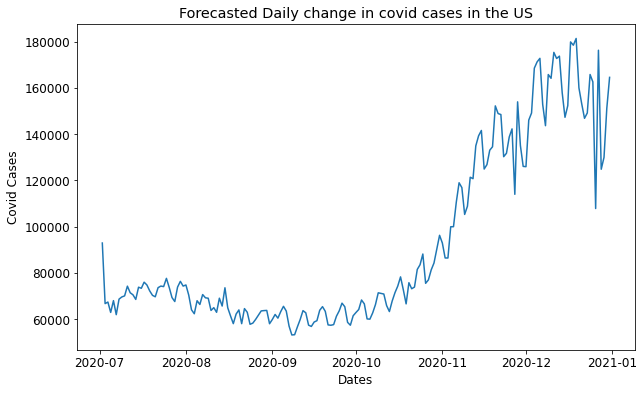

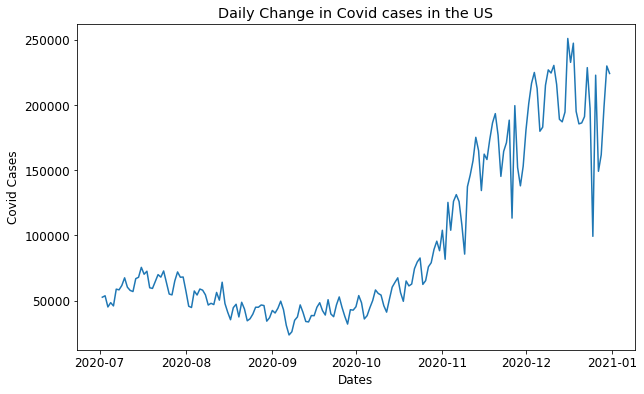

In [43]:
#Graph for the US forecast vs Actual
df_US_F = df_US_forecast[['FIPS','Confirmed']]
df_US_F = df_US_F[df_US_F['FIPS']>0]
df_US_F = df_US_F.resample('1d').sum()
df_US_F = df_US_F['Confirmed'] 
df_US_F = df_US_F.reset_index()
df_US_F.head()

plt.rc('font', size=12)
fig2, ax2 = plt.subplots(figsize=(10, 6))

ax2.plot(df_US_F.as_of_date, df_US_F.Confirmed, color='tab:blue', label='Windspeed')

ax2.set_xlabel('Dates')
ax2.set_ylabel('Covid Cases')
ax2.set_title('Forecasted Daily change in covid cases in the US')


plt.rc('font', size=12)
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_US.as_of_date, df_US.Confirmed.diff(), color='tab:blue', label='Windspeed')

ax1.set_xlabel('Dates')
ax1.set_ylabel('Covid Cases')
ax1.set_title('Daily Change in Covid cases in the US')

In [44]:
ARIMA_forecast = df_US_F
Actual_data = df_US
Actual_data.head()
ARIMA_forecast['forecasted_confirmed'] = ARIMA_forecast['Confirmed']
Actual_data['Confirmed'] = Actual_data['Confirmed'].diff().dropna()
ARIMA_data_for_analysis = Actual_data.merge(ARIMA_forecast[['as_of_date','forecasted_confirmed']], 
                                            how='left', left_on='as_of_date', right_on='as_of_date')
ARIMA_data_for_analysis.head()

,as_of_date,Confirmed
0,2020-07-01,2655135
1,2020-07-02,2707665
2,2020-07-03,2761290
3,2020-07-04,2806342
4,2020-07-05,2854711


,as_of_date,Confirmed,forecasted_confirmed
0,2020-07-01,NaN,NaN
1,2020-07-02,52530.0,92924.124799
2,2020-07-03,53625.0,66734.116117
3,2020-07-04,45052.0,67407.841420
4,2020-07-05,48369.0,62927.563299


In [45]:
ARIMA_for_plots = ARIMA_data_for_analysis.set_index('as_of_date') 

<Figure size 1080x720 with 0 Axes>

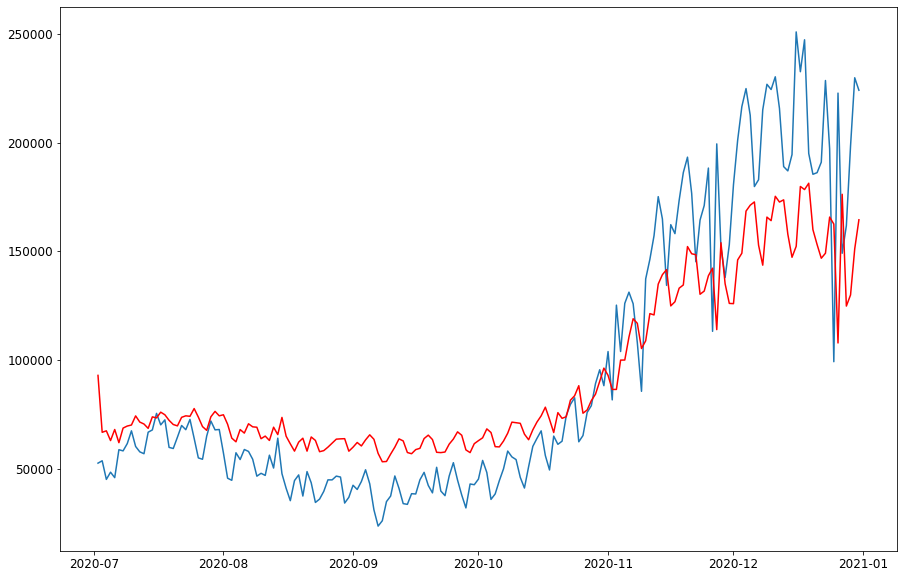

In [46]:
plt.figure(figsize=(15,10))
plt.plot(ARIMA_for_plots.Confirmed)
plt.plot(ARIMA_for_plots.forecasted_confirmed, color = 'red')

In [47]:
#Model Scoring MAD = Mean Absolute Deviation MAPE = Mean absolute percentage error
ARIMA_for_plots['MAD'] = np.abs(ARIMA_for_plots['Confirmed']-ARIMA_for_plots['forecasted_confirmed'])
ARIMA_for_plots['MAPE'] = np.abs((ARIMA_for_plots['Confirmed']-ARIMA_for_plots['forecasted_confirmed'])/ARIMA_for_plots['Confirmed'])
MAD = np.mean(ARIMA_for_plots['MAD'])*100
MAPE = np.mean(ARIMA_for_plots['MAPE'])
print('The MAD for the forecast was: '+str(int(MAD)))
print('The MAPE for the forecast was: '+'{:.1%}'.format(MAPE))

The MAD for the forecast was: 2320256
The MAPE for the forecast was: 30.2%


## Conclusions from ARIMA model
The ARIMA model presented us with a forecast with a bit under 30% of innacuracy (based on MAPE), understandably, this forecast is being derived using a sum of other forecasts which is part of the reason why it is likely biased, so for the purposes of covid forecasting we would deem this model to be somewhat innacurate at forecasting future Covid cases, even though the overall trend line appears to be closely related to the actual numbers.  

## 7.2 VAR (Vector Autoregressive Model
Given what previous literature on Covid suggests, weather plays an important role in the increase of the spread of the virus with colder climates having a considerable correlation with higher incidence of Covid. To test the magnitude of this relationship we will be performing a series of tests such as an Augmented Dickey-Fuller Test (ADF Test).


In [58]:
#importing packages for this analysis
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [59]:
#importing weather data
weather_data = pd.read_csv('Weather Data\Full_Panel_01_12_Weather.csv', encoding='latin1')
weather_data.head()

,Unnamed: 0,Unnamed: 0.1,cty,FIPS,STATE & COUNTY,YEAR,MONTH,TAVG,variable,value
0,0,0,cty,1001,AL: Autauga,2020,1,TAVG,1/1/2020,7.36
1,1,1,cty,1003,AL: Baldwin County,2020,1,TAVG,1/1/2020,10.48
2,2,2,cty,1005,AL: Barbour County,2020,1,TAVG,1/1/2020,8.73
3,3,3,cty,1007,AL: Bibb County,2020,1,TAVG,1/1/2020,6.09
4,4,4,cty,1009,AL: Blount County,2020,1,TAVG,1/1/2020,5.90


In [60]:
#data cleaning
weather_data = weather_data.rename(columns={"value": "Avg_Temp", "variable": "as_of_date"})
weather_data = weather_data[['FIPS', 'STATE & COUNTY', 'YEAR',
       'MONTH', 'TAVG', 'as_of_date', 'Avg_Temp']]
weather_data.head()

,FIPS,STATE & COUNTY,YEAR,MONTH,TAVG,as_of_date,Avg_Temp
0,1001,AL: Autauga,2020,1,TAVG,1/1/2020,7.36
1,1003,AL: Baldwin County,2020,1,TAVG,1/1/2020,10.48
2,1005,AL: Barbour County,2020,1,TAVG,1/1/2020,8.73
3,1007,AL: Bibb County,2020,1,TAVG,1/1/2020,6.09
4,1009,AL: Blount County,2020,1,TAVG,1/1/2020,5.90


Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Avg Temp (Celcius)')

Text(0.5, 1.0, 'Weather for full calendar year (Celcius) in FIPS=45001')

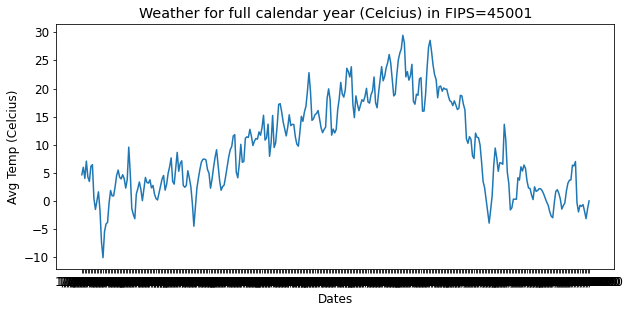

In [61]:
#exploratory data analysis
FIP_for_graph = 45001
weather_data_1 = weather_data[weather_data['FIPS']==FIP_for_graph] 

fig_w, ax_w = plt.subplots(figsize=(10, 4.5))

ax_w.plot(weather_data_1.as_of_date, weather_data_1.Avg_Temp, color='tab:blue', label='Avg Temp')

ax_w.set_xlabel('Dates')
ax_w.set_ylabel('Avg Temp (Celcius)')
ax_w.set_title('Weather for full calendar year (Celcius) in FIPS='+str(FIP_for_graph))

Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Avg Temp (Celcius)')

Text(0.5, 1.0, 'Weather for full calendar year (Celcius) in FIPS=16001')

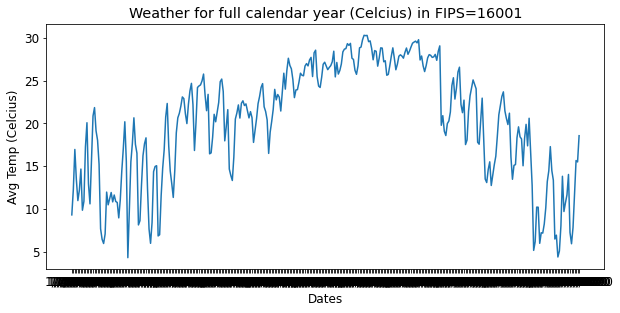

In [62]:
FIP_for_graph = 16001
weather_data_1 = weather_data[weather_data['FIPS']==FIP_for_graph] 

fig_w, ax_w = plt.subplots(figsize=(10, 4.5))

ax_w.plot(weather_data_1.as_of_date, weather_data_1.Avg_Temp, color='tab:blue', label='Avg Temp')

ax_w.set_xlabel('Dates')
ax_w.set_ylabel('Avg Temp (Celcius)')
ax_w.set_title('Weather for full calendar year (Celcius) in FIPS='+str(FIP_for_graph))

In [63]:
#Main covid data frame
df_main = df_mapped_for_joins
weather_data['as_of_date']= pd.to_datetime(weather_data['as_of_date'])
weather_data['FIPS']= pd.to_numeric(weather_data['FIPS'])
df_main
covid_w_weather = df_main.merge(weather_data, how='left', left_on=['as_of_date','FIPS'], right_on=['as_of_date','FIPS'])
covid_w_weather[covid_w_weather['FIPS']>0].shape
covid_w_weather.info()
weather_data_FIPS = weather_data['FIPS'].unique() 
weather_data_FIPS = [x for x in weather_data_FIPS]
len(weather_data_FIPS)

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,as_of_date,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio,State,Code
0,0,45001.0,Abbeville,South Carolina,US,2020-07-02 04:33:46,34.223334,-82.461707,113,0.0,0.0,113.0,"Abbeville, South Carolina, US",2020-07-01,460.716761,0.000000,NaN,NaN,Abbeville County,SC
1,1,22001.0,Acadia,Louisiana,US,2020-07-02 04:33:46,30.295065,-92.414197,919,37.0,0.0,882.0,"Acadia, Louisiana, US",2020-07-01,1481.183012,4.026115,NaN,NaN,Acadia Parish,LA
2,2,51001.0,Accomack,Virginia,US,2020-07-02 04:33:46,37.767072,-75.632346,1043,14.0,0.0,1029.0,"Accomack, Virginia, US",2020-07-01,3227.503404,1.342282,NaN,NaN,Accomack County,VA
3,3,16001.0,Ada,Idaho,US,2020-07-02 04:33:46,43.452658,-116.241552,2288,23.0,0.0,2265.0,"Ada, Idaho, US",2020-07-01,475.095881,1.005245,NaN,NaN,Ada County,ID
4,4,19001.0,Adair,Iowa,US,2020-07-02 04:33:46,41.330756,-94.471059,15,0.0,0.0,15.0,"Adair, Iowa, US",2020-07-01,209.731544,0.000000,NaN,NaN,Adair County,IA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583275,3917,56037.0,Sweetwater,Wyoming,US,2021-01-01 05:23:07,41.659439,-108.882788,2966,16.0,0.0,2950.0,"Sweetwater, Wyoming, US",2020-12-31,NaN,NaN,7004.699714,0.539447,Sweetwater County,WY
583276,3918,56039.0,Teton,Wyoming,US,2021-01-01 05:23:07,43.935225,-110.589080,2138,4.0,0.0,2134.0,"Teton, Wyoming, US",2020-12-31,NaN,NaN,9111.830890,0.187091,Teton County,WY
583277,3919,56041.0,Uinta,Wyoming,US,2021-01-01 05:23:07,41.287818,-110.547578,1558,7.0,0.0,1551.0,"Uinta, Wyoming, US",2020-12-31,NaN,NaN,7702.956591,0.449294,Uinta County,WY
583278,3921,56043.0,Washakie,Wyoming,US,2021-01-01 05:23:07,43.904516,-107.680187,781,19.0,0.0,762.0,"Washakie, Wyoming, US",2020-12-31,NaN,NaN,10006.406150,2.432778,Washakie County,WY


(583280, 25)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583280 entries, 0 to 583279
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           583280 non-null  int64         
 1   FIPS                 583280 non-null  float64       
 2   Admin2               583280 non-null  object        
 3   Province_State       583280 non-null  object        
 4   Country_Region       583280 non-null  object        
 5   Last_Update          583280 non-null  object        
 6   Lat                  583280 non-null  float64       
 7   Long_                583280 non-null  float64       
 8   Confirmed            583280 non-null  int64         
 9   Deaths               583280 non-null  float64       
 10  Recovered            583280 non-null  float64       
 11  Active               583280 non-null  float64       
 12  Combined_Key         583280 non-null  object        
 13  as_of_date    

3107

In [64]:
#It appears that some values are not getting mapped from my weather data
missing_FIPS = [list(set(df_main['FIPS']).difference(weather_data['FIPS']))]
missing_FIPS = [x for x in missing_FIPS]
missing_FIPS = missing_FIPS[0]
len(missing_FIPS)

1600

#### Note 
It appears there's 1600 FIPS missing from our weather data repository, it is likely due to the fact that weather data does not take into consideration every single individual county in the US, for the purposes of this analysis we will drop any rows where data is missing

In [65]:
#clean_master_data
covid_w_weather_clean = covid_w_weather[covid_w_weather['MONTH']>0] 
covid_w_weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243486 entries, 0 to 582705
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           243486 non-null  int64         
 1   FIPS                 243486 non-null  float64       
 2   Admin2               243486 non-null  object        
 3   Province_State       243486 non-null  object        
 4   Country_Region       243486 non-null  object        
 5   Last_Update          243486 non-null  object        
 6   Lat                  243486 non-null  float64       
 7   Long_                243486 non-null  float64       
 8   Confirmed            243486 non-null  int64         
 9   Deaths               243486 non-null  float64       
 10  Recovered            243486 non-null  float64       
 11  Active               243486 non-null  float64       
 12  Combined_Key         243486 non-null  object        
 13  as_of_date    

In [66]:
#Keep only the columns needed for my analysis
covid_w_weather_clean = covid_w_weather_clean[['FIPS','as_of_date','Confirmed','Avg_Temp']]
covid_w_weather_clean.head()

,FIPS,as_of_date,Confirmed,Avg_Temp
0,45001.0,2020-07-01,113,17.24
1,22001.0,2020-07-01,919,28.31
3,16001.0,2020-07-01,2288,29.29
4,19001.0,2020-07-01,15,20.62
5,21001.0,2020-07-01,121,23.84


In [67]:
#To test whether our Covid Data follows a random walk or not we will take FIPS 16001
result = adfuller(covid_w_weather_clean[covid_w_weather_clean['FIPS']==16001]['Confirmed'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

ADF Statistic: 5.306005
p-value: 1.000000
Critical Values:


##### Based on the Augmented Dickey-Fuller Test the Covid dataset follows a random walk

In [68]:
#To test whether our Covid Data follows a random walk or not we will take FIPS 16001
result = adfuller(covid_w_weather_clean[covid_w_weather_clean['FIPS']==16001]['Confirmed'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

ADF Statistic: -2.388372
p-value: 0.145045
Critical Values:


##### Based on the Augmented Dickey-Fuller Test the 1st DIFFERENCE Covid dataset most likelyfollows a random walk - but for the purposes of this analysis we will allow this.

In [38]:
#To test whether our weather Data follows a random walk or not we will take FIPS 16001
result = adfuller(covid_w_weather_clean[covid_w_weather_clean['FIPS']==16001]['Avg_Temp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

ADF Statistic: -0.986441
p-value: 0.758177
Critical Values:


##### Based on the Augmented Dickey-Fuller Test the weather data follows a random walk as well, since even though it is negative (i.e. it is less of a random walk than the Covid numbers) it is not negative enough to reject the null hypothesis of stationarity/non-random walk.

In [70]:
#To test whether our weather Data follows a random walk or not we will take FIPS 16001
result = adfuller(covid_w_weather_clean[covid_w_weather_clean['FIPS']==16001]['Avg_Temp'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

ADF Statistic: -5.814262
p-value: 0.000000
Critical Values:


##### Based on the Augmented Dickey-Fuller Test the weather data 1st DIFFERENCE DOES NOT follow a random walk

#### Now that we have established both plain variables are random walks, and made them stationary by performing a first order differencing can we determine whether they are cointegrated?

In [71]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    return cointegration_test(df)

In [72]:
#Prepare data for cointegration test
covid_weather = covid_w_weather_clean
covid_weather = covid_w_weather_clean.set_index('as_of_date')
covid_weather = covid_weather[['Confirmed','Avg_Temp','FIPS']]
cointegration_test(covid_weather)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950.36  > 24.2761   =>   True
Avg_Temp ::  1848.97   > 12.3212   =>   True
FIPS   ::  198.5     > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  25950

KeyboardInterrupt: 

### Conclusions so far
1) The weather and Covid figures are both non-stationary random walks

2) Weather patterns and Covid figures are co-integrated

3) We can run a VAR model with full certainty

### Data Preparation, Model Specification & Calibration
Note: based on the previous analysis, the data becomes stationary (i.e. does not follow a random walk) after we differenced

In [73]:
#Difference the data twice for this analysis use FIPS 16001 for this analysis
differenced_data = covid_weather[covid_weather['FIPS']==16001]
differenced_data['Confirmed'] = differenced_data['Confirmed'].diff().dropna()
differenced_data['Avg_Temp'] = differenced_data['Avg_Temp'].diff().dropna()
differenced_data = differenced_data[['Confirmed','Avg_Temp']]
differenced_data = differenced_data.dropna()
differenced_data.head()

<ipython-input-73-7cf22d39bda7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_data['Confirmed'] = differenced_data['Confirmed'].diff().dropna()
<ipython-input-73-7cf22d39bda7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_data['Avg_Temp'] = differenced_data['Avg_Temp'].diff().dropna()


,Confirmed,Avg_Temp
as_of_date,,
2020-07-02,48.0,-0.20
2020-07-03,171.0,0.23
2020-07-04,124.0,-1.72
2020-07-05,204.0,-0.15
2020-07-06,165.0,-1.26


In [92]:
VAR_data = differenced_data
nobs = 30
df_train, df_test = VAR_data[0:-nobs], VAR_data[-nobs:]


#Specify the model and run the different parameters to find the optimal parameters
model = VAR(VAR_data)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    
x = model.select_order(maxlags=12)
x.summary()

Lag Order = 1
AIC :  12.344029338791998
BIC :  12.463393043562245
FPE :  229587.52132448502
HQIC:  12.39251902146603 

Lag Order = 2
AIC :  12.37126640351941
BIC :  12.57108626026212
FPE :  235935.75997926935
HQIC:  12.452443611687006 

Lag Order = 3
AIC :  12.39917394921747
BIC :  12.680166576666453
FPE :  242634.05305507698
HQIC:  12.513332322173884 

Lag Order = 4
AIC :  12.443654382600297
BIC :  12.806547224929279
FPE :  253710.4322552822
HQIC:  12.591091745308574 

Lag Order = 5
AIC :  12.467056112095719
BIC :  12.9125876663039
FPE :  259783.88883734422
HQIC:  12.648074553412167 

Lag Order = 6
AIC :  12.481425538173404
BIC :  13.01034558753563
FPE :  263643.2314484134
HQIC:  12.696331490762844 

Lag Order = 7
AIC :  12.506523038298248
BIC :  13.119592892073932
FPE :  270486.70267847495
HQIC:  12.755627360274202 

Lag Order = 8
AIC :  12.557074163566655
BIC :  13.255066903168721
FPE :  284714.0974644486
HQIC:  12.840692221891857 

Lag Order = 9
AIC :  12.572181720385615
BIC :  13.

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,AIC,BIC,FPE,HQIC
0,12.51,12.55*,2.707e+05,12.53*
1,12.48*,12.61,2.630e+05*,12.53
2,12.50,12.71,2.676e+05,12.58
3,12.52,12.81,2.739e+05,12.64
4,12.55,12.93,2.833e+05,12.71
5,12.57,13.03,2.875e+05,12.76
6,12.57,13.11,2.882e+05,12.79
7,12.58,13.21,2.916e+05,12.84
8,12.62,13.33,3.037e+05,12.91
9,12.62,13.42,3.038e+05,12.94


Based on the analysis above, the AIC dropped to its lowest level on Lag = 1 before increasing and dropping again. Therefore we should specify this model with an order of Lag = 1. Based on the BIC this model would have a lag of 0 however. For the purposes of this analysis we will perform VAR with a Lag = 1. 

In [93]:
#The fitted model with a lag of 1 is specified as follows
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jan, 2021
Time:                     22:23:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.4634
Nobs:                     152.000    HQIC:                   12.3925
Log likelihood:          -1363.50    FPE:                    229588.
AIC:                      12.3440    Det(Omega_mle):         220786.
--------------------------------------------------------------------
Results for equation Confirmed
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              185.259897        25.376119            7.301           0.000
L1.Confirmed         0.219945         0.081422            2.701           0.007
L1.Avg_Temp          4.169760         7.471270            0.

In [94]:
#The next step will be to perform a Durbin-Watson test to check if the residuals have any unexplained variance.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(VAR_data.columns, out):
    print(col, ':', round(val, 2))

Confirmed : 2.06
Avg_Temp : 1.95


The Durbin-Watson statistic will always assume a value between 0 and 4. A value of DW = 2 indicates that there is no autocorrelation. When the value is below 2, it indicates a positive autocorrelation, and a value higher than 2 indicates a negative serial correlation. In this case, the correlations look good.

In [96]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 1
steps = lag_order

# Input data for forecasting
forecast_input = VAR_data.values[-lag_order:]
forecast_input

1


array([[402.  ,   3.05]])

In [100]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_VAR_forecast = pd.DataFrame(fc, index=VAR_data.index[-nobs:], columns=VAR_data.columns + '_2d')
len(df_VAR_forecast)
df_VAR_forecast.head()

30

,Confirmed_2d,Avg_Temp_2d
as_of_date,,
2020-12-02,286.395420,0.472575
2020-12-03,250.221564,0.062034
2020-12-04,240.553461,-0.030534
2020-12-05,238.041028,-0.053719
2020-12-06,237.391756,-0.059665


In [98]:
df_results = df_VAR_forecast

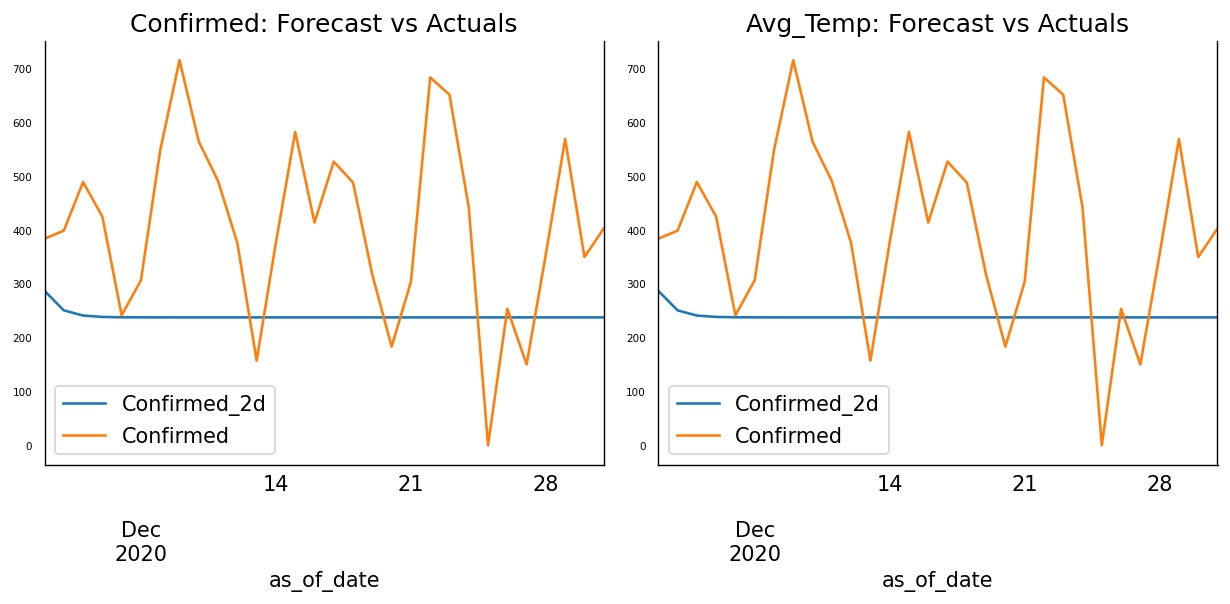

In [119]:
# Plot of Forecast vs Actuals
fig, axes = plt.subplots(nrows=int(len(VAR_data.columns)/2), ncols=2, dpi=125, figsize=(10,5))
for i, (col,ax) in enumerate(zip(VAR_data.columns, axes.flatten())):
    df_results['Confirmed_2d'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test['Confirmed'][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [125]:
#Dataframe for MAD and MAPE analyses 
df_results.head()
df_test.head() 
VAR_for_plots = df_test.merge(df_results, how='left', left_on='as_of_date',right_on='as_of_date')
VAR_for_plots.head(30)

,Confirmed_2d,Avg_Temp_2d
as_of_date,,
2020-12-02,286.395420,0.472575
2020-12-03,250.221564,0.062034
2020-12-04,240.553461,-0.030534
2020-12-05,238.041028,-0.053719
2020-12-06,237.391756,-0.059665


,Confirmed,Avg_Temp
as_of_date,,
2020-12-02,383.0,1.01
2020-12-03,398.0,4.02
2020-12-04,488.0,-0.01
2020-12-05,424.0,-4.20
2020-12-06,241.0,1.23


,Confirmed,Avg_Temp,Confirmed_2d,Avg_Temp_2d
as_of_date,,,,
2020-12-02,383.0,1.01,286.395420,0.472575
2020-12-03,398.0,4.02,250.221564,0.062034
2020-12-04,488.0,-0.01,240.553461,-0.030534
2020-12-05,424.0,-4.20,238.041028,-0.053719
2020-12-06,241.0,1.23,237.391756,-0.059665
2020-12-07,306.0,-0.04,237.224158,-0.061197
2020-12-08,547.0,1.06,237.180906,-0.061593
2020-12-09,714.0,1.88,237.169744,-0.061695
2020-12-10,563.0,3.06,237.166864,-0.061721


In [131]:
#Model Scoring MAD = Mean Absolute Deviation MAPE = Mean absolute percentage error
VAR_for_plots['MAD'] = np.abs(VAR_for_plots['Confirmed']-VAR_for_plots['Confirmed_2d'])
VAR_for_plots['MAPE'] = np.abs((VAR_for_plots['Confirmed']-VAR_for_plots['Confirmed_2d'])/VAR_for_plots['Confirmed'])
VAR_for_plots = VAR_for_plots.replace([np.inf, -np.inf], 0)
MAD = np.mean(VAR_for_plots['MAD'])*100
MAPE = np.mean(VAR_for_plots['MAPE'])
print('The MAD for the forecast was: '+str(int(MAD)))
print('The MAPE for the forecast was: '+'{:.1%}'.format(MAPE))

The MAD for the forecast was: 19521
The MAPE for the forecast was: 40.9%


## Conclusions from VAR model
The VAR model presented us with a forecast with a bit under 40% of innacuracy (based on MAPE), it should be noted this forecast is being derived for a single US FIPS, however it could be argued that the level of accuracy of the overall forecast is rather low and inferior to that of ARIMA.

# 8. Conclusions so far
So far, I would state that the best model I have is the ARIMA model with 70% accuracy rate, since it is superior to the VAR model